In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

In [4]:
def coalescence_time(f, chirp_mass):
    'Coalescence time of BBH merger'
    return 5 * (8 * np.pi * f)**(-8/3) * chirp_mass**(-5/3)

def freq(t, tc, chirp_mass):
    'finding frequency as function of time'
    return (((tc - t)/5)**(-3/8)) / (8*np.pi*(chirp_mass**(5/8)))

def phase(tc, t, ch_mass, phi_c):   #what is this called?????
    return phi_c - 2 * ((tc - t)/(5 * ch_mass))**(5/8)

def phi_t_Lbar(time, phi_0):
    'LISA orbital phase'
    return phi_0 + (2*np.pi*time/constants.year)

def theta_s_t(theta_sbar, phi_t_Lbar, phi_sbar):
    'Source location'
    cos_theta = 0.5 * np.cos(theta_sbar) - (np.sqrt(3)/2)*np.sin(theta_sbar)*np.cos(phi_t_Lbar-phi_sbar)
    return np.arccos(cos_theta)

def alpha_i_t(i, t, alpha_0):
    'LISA Arm orientation'
    T = 31536000
    return 2*np.pi*t/T - np.pi/12 - (i-1)*np.pi/3 + alpha_0

def phi_s_t(theta_sbar, phi_t_bar, phi_s_bar, alpha1):
    'Source location in (unbarred) detector frame'
    return alpha1 + np.pi/12 + np.arctan((np.sqrt(3)*np.cos(theta_sbar) + np.sin(theta_sbar)*np.cos(phi_t_bar - phi_sbar))\
                                   /(2*np.sin(theta_sbar)*np.sin(phi_t_bar - phi_sbar)) )

def psi_s_t(theta_Lbar, phi_Lbar, theta_sbar, phi_sbar, phi_t_Lbar):
    'Polarisation angle'
    L_dot_z = 0.5 * np.cos(theta_Lbar) - ( (np.sqrt(3)/2) * np.sin(theta_Lbar) * np.cos(phi_t_Lbar - phi_Lbar) )
    #print(L_dot_z)
    L_dot_n = np.cos(theta_Lbar)*np.cos(theta_sbar) + np.sin(theta_Lbar)*np.sin(theta_sbar)*np.cos(phi_Lbar - phi_sbar)
    global cos_i
    cos_i = L_dot_n
    
    cross = (0.5*np.sin(theta_Lbar)*np.sin(theta_sbar)*np.sin(phi_Lbar - phi_sbar)) - \
    (np.sqrt(3)/2)*np.cos(phi_t_Lbar)*( (np.cos(theta_Lbar)*np.sin(theta_sbar)*np.sin(phi_sbar) - \
                                      np.cos(theta_sbar)*np.sin(theta_Lbar)*np.sin(phi_Lbar)) )\
    - (np.sqrt(3)/2)*np.sin(phi_t_Lbar)*(np.cos(theta_sbar)*np.sin(theta_Lbar)*np.cos(phi_Lbar) - \
                                      np.cos(theta_Lbar)*np.sin(theta_sbar)*np.cos(phi_sbar))
    
    tan_psi = (L_dot_z - L_dot_n * np.cos(theta_s_t_)) / cross
    
    return np.arctan(tan_psi)

def doppler_phase(f, theta_sbar, phi, phi_sbar):
    'doppler phase due to LISA motion'
    R = constants.astronomical_unit/constants.speed_of_light
    return 2 * np.pi * f * R * np.sin(theta_sbar) * np.cos(phi - phi_sbar)

def F_plus(theta_s, phi_s, psi_s):
    'Detector Beam Pattern Coefficient'
    return (0.5 * (1 + np.cos(theta_s)**2) * np.cos(2*phi_s) * np.cos(2*psi_s)) - \
                        (np.cos(theta_s) * np.sin(2*phi_s) * np.sin(2*psi_s) )

def F_cross(theta_s, phi_s, psi_s):
    'Detector Beam Pattern Coefficient'
    return (0.5 * (1+np.cos(theta_s)**2) * np.cos(2*phi_s) * np.sin(2*psi_s)) + \
                        (np.cos(theta_s) * np.sin(2*phi_s) * np.cos(2*psi_s))

def phi_P_I_t(cos_i, F_plus, F_cross): #change to phi
    'Polarisation Phase'
    return np.arctan( (2*cos_i*F_cross)/((1 + (cos_i**2))*F_plus) )

def A_t(M_c, f, D_L):
    'Waveform Amplitude'
    return 2 * M_c**(5/3) * (np.pi*f)**(2/3) / D_L

def A_p_t(F_plus, F_cross, cos_i):
    'Polarization Amplitude'
    return np.sqrt(3)/2 * (((1+cos_i**2)**2 * F_plus**2) + (4 * cos_i**2 * F_cross**2))**(1/2) 

def h_t(A_t, A_p_t, phase, phi_P_I_t, doppler_phase):
    'Strain signal'
    return A_t * A_p_t * np.cos(phase + phi_P_I_t + doppler_phase)

In [12]:
#defining variables
strain_list = []
for i in range(int(10**6), int(10**7), int(9e5)):
    chirp_mass = i
    Nsamples = 10000
    theta_Lbar = np.pi/5
    phi_Lbar = np.pi/11
    theta_sbar = 2*np.pi/7
    phi_sbar = 7*np.pi/12
    alpha_0 = 0
    phi_0 = 0
    phi_c = 0
    det_no = 1
    fmin = 1e-4
    m_sun = 1.98840987e30 * constants.G / (constants.c**3)                    #solar mass in seconds
    M_c = chirp_mass * m_sun                                                  #chirp mass in seconds
    D_L = constants.parsec * 1e9 / constants.speed_of_light                   #luminosity distance in seconds (1Gpc).

    #calculating coalescence time, f_isco and t_isco
    tc = coalescence_time(fmin, M_c)                                          
    f_isco = 1 / (np.pi * 6**(3/2) * 2**(6/5) *M_c)
    t_isco = tc - 5 * (8*np.pi*f_isco)**(-8/3) * M_c**(-5/3)
    #time and frequency arrays
    t = np.linspace(0, t_isco, Nsamples)                                     
    f = freq(t, tc, M_c)

    #params
    phi = phase(tc, t, M_c, phi_c)
    phi_t_Lbar_ = phi_t_Lbar(t, phi_0)
    theta_s_t_ = theta_s_t(theta_sbar, phi_t_Lbar_, phi_sbar)
    alpha_t_ = alpha_i_t(det_no, t, alpha_0)
    phi_s_t_ = phi_s_t(theta_sbar, phi_t_Lbar_, phi_sbar, alpha_t_)
    psi_s_t_ = psi_s_t(theta_Lbar, phi_Lbar, theta_sbar, phi_sbar, phi_t_Lbar_)
    doppler_phase_ = doppler_phase(f, theta_sbar, phi_t_Lbar_, phi_sbar)
    F_plus_ = F_plus(theta_s_t_, phi_s_t_, psi_s_t_)
    F_cross_ = F_cross(theta_s_t_, phi_s_t_, psi_s_t_)
    phi_P_I_t_ = phi_P_I_t(cos_i, F_plus_, F_cross_)
    A_t_ = A_t(M_c, f, D_L)
    A_p_t_ = A_p_t(F_plus_, F_cross_, cos_i)
    strain = h_t(A_t_, A_p_t_, phi, phi_P_I_t_, doppler_phase_)
    strain_list.append(strain)
print(strain_list)

[array([-7.26744749e-19, -7.31755042e-19, -7.10783277e-19, ...,
       -1.93503376e-18,  1.41211738e-18,  5.98164923e-19]), array([ 1.47128348e-18,  1.36817562e-18,  1.25934838e-18, ...,
       -2.18773794e-18, -6.85720899e-18, -8.95939557e-18]), array([-3.25444990e-18, -3.16981180e-18, -3.08156032e-18, ...,
       -1.05019405e-17, -1.22372974e-17, -1.33623400e-17]), array([-1.98644239e-18, -1.85597706e-18, -1.72467854e-18, ...,
       -1.64713780e-17, -1.73151543e-17, -1.79627579e-17]), array([ 1.66391773e-18,  1.53068416e-18,  1.39711805e-18, ...,
       -2.17842070e-17, -2.22699838e-17, -2.26776363e-17]), array([ 1.19152742e-17,  1.19570888e-17,  1.19975587e-17, ...,
       -2.68472367e-17, -2.71578549e-17, -2.74325590e-17]), array([ 4.28873345e-18,  4.16248518e-18,  4.03595422e-18, ...,
       -3.17920279e-17, -3.20048832e-17, -3.21995024e-17]), array([-2.01302665e-17, -2.01333692e-17, -2.01356617e-17, ...,
       -3.66722111e-17, -3.68252001e-17, -3.69682516e-17]), array([-2.16139

In [6]:
strain = h_t(A_t_, A_p_t_, phi, phi_P_I_t_, doppler_phase_)

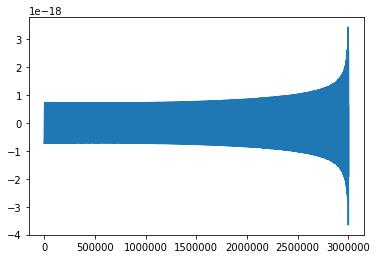

In [7]:
plt.plot(t, strain)